In [106]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from PIL import Image
import cv2 as cv

In [2]:
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [38]:
df = pd.read_pickle("MIR-WM811K\\Python\\WM811K.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dieSize         811457 non-null  float64
 1   failureType     811457 non-null  object 
 2   lotName         811457 non-null  object 
 3   trainTestLabel  811457 non-null  object 
 4   waferIndex      811457 non-null  float64
 5   waferMap        811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [39]:
df.head()

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap
0,1683.0,none,lot1,Training,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1683.0,none,lot1,Training,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1683.0,none,lot1,Training,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1683.0,none,lot1,Training,4.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1683.0,none,lot1,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [40]:
df.tail()

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap
811452,600.0,Edge-Ring,lot47542,Test,23.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."
811453,600.0,Edge-Loc,lot47542,Test,24.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,..."
811454,600.0,Edge-Ring,lot47542,Test,25.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."
811455,600.0,"[0, 0]",lot47543,"[0, 0]",1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,..."
811456,600.0,"[0, 0]",lot47543,"[0, 0]",2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."


In [ ]:
unique_index = np.unique(df.waferIndex, return_counts=True)


In [42]:
def find_dim(x):
    dim0 = np.size(x, axis=0)
    dim1 = np.size(x, axis=1)
    return (dim0, dim1)

df['waferMapDim'] = df.waferMap.apply(find_dim)
df.sample(5)

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap,waferMapDim
135210,1620.0,"[0, 0]",lot8838,"[0, 0]",24.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(37, 55)"
601545,1513.0,"[0, 0]",lot37836,"[0, 0]",22.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(49, 39)"
763443,1108.0,none,lot45587,Test,24.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...","(39, 37)"
139988,811.0,"[0, 0]",lot9097,"[0, 0]",15.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...","(34, 31)"
666137,712.0,"[0, 0]",lot41474,"[0, 0]",20.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...","(32, 29)"


In [43]:
max(df['waferMapDim']), min(df['waferMapDim'])

((300, 202), (6, 21))

In [44]:
unique_waferDim = np.unique(df['waferMapDim'])
unique_waferDim.shape

(632,)

In [45]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trainTestLabel

mapping_type={
    'Center':0,
    'Donut':1,
    'Edge-Loc':2,
    'Edge-Ring':3,
    'Loc':4,
    'Random':5,
    'Scratch':6,
    'Near-full':7,
    'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

C:\Users\User\anaconda3\Lib\site-packages\pandas\core\array_algos\replace.py:84: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [46]:
newData = df[df['failureNum'].apply(lambda x: isinstance(x, int))]

In [47]:
df_label = newData[(newData['failureNum']>=0) & (newData['failureNum']<=8)]
df_label = df_label.reset_index()
df_pattern = newData[(newData['failureNum']>=0) & (newData['failureNum']<=7)]
df_pattern = df_pattern.reset_index()
df_none = newData[(newData['failureNum']==8)]

df_label.shape[0], df_pattern.shape[0], df_none.shape[0]

(172950, 25519, 147431)

In [48]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [ ]:
del df
del df_pattern
del df_none

In [54]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPool2D
from tensorflow.keras.layers import Flatten, Softmax, SpatialDropout2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [57]:
map_encoding=pd.read_excel('MapEncoding.xlsx')
map_encoding

,Unnamed: 0,Type,Value
0,0,Center,0
1,1,Donut,1
2,2,Edge-Loc,2
3,3,Edge-Ring,3
4,4,Loc,4
5,5,Random,5
6,6,Scratch,6
7,7,Near-full,7
8,8,none,8


In [58]:
map_encoding.drop('Unnamed: 0',axis=1,inplace=True)

In [73]:
dic=map_encoding.to_dict()
dic=dic['Type']

In [153]:
df_label[df_label['failureNum'] == 1].sample(10)

,index,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap,waferMapDim,failureNum,trainTestNum
20493,279838,1334.0,Donut,lot17174,Training,12.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(41, 42)",1,0
20356,279259,1334.0,Donut,lot17141,Training,23.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(41, 42)",1,0
126198,762985,1109.0,Donut,lot45569,Test,9.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...","(39, 37)",1,1
20347,279232,1334.0,Donut,lot17139,Training,21.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(41, 42)",1,0
8335,31704,3036.0,Donut,lot3108,Training,6.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(63, 62)",1,0
134694,771845,1376.0,Donut,lot45929,Test,9.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(44, 41)",1,1
51273,680765,838.0,Donut,lot42240,Test,15.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...","(35, 31)",1,1
25146,439891,712.0,Donut,lot26738,Training,11.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,...","(32, 29)",1,0
20331,279135,1334.0,Donut,lot17134,Training,23.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(41, 42)",1,0
6508,7335,1620.0,Donut,lot534,Training,7.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(37, 55)",1,0


In [86]:


def reshape_images(images, height, width):
    reshaped_images = np.zeros((len(images), height, width, 3))
    for n in range(len(images)):
        for h in range(height):
            for w in range(width):
                reshaped_images[n, h, w, images[n][h][w]] = 1
    return reshaped_images

def augment_images(images, number=None):
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            rotate=(-180, 180),
            shear=(-8, 8)
        ),
    ], random_order=True)
    
    images_input = np.random.choice(images, number) if number else images
    images_expanded = []
    for image in images_input:
        images_expanded.append(image)
    images_expanded = np.array(images_expanded)
    images_augmented = seq(images=images_expanded)
    return images_augmented

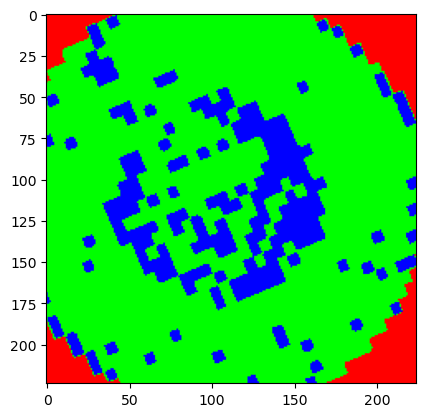

In [118]:
plt.imshow(reshaped[-1])

In [164]:
output_path="NewAugmentation"
k=0
for j in range(1):
    x_train, y_train = [], []
    for failureNum in range(class_num):
        
        folder_path=os.path.join(output_path,dic[failureNum])
        os.makedirs(folder_path,exist_ok=True)
        extracted = df_label[df_label['failureNum'] == failureNum].sample(20, replace=True).waferMap
        resized = extracted.apply(lambda x:cv.resize(x, dsize=dsize, interpolation=cv.INTER_AREA))
        del extracted
        augmented = np.array(augment_images(resized))
        reshaped = reshape_images(augmented, dsize[1], dsize[0])
        del augmented
        
        
        labels = np.zeros((count_per_class, class_num))
        for i in range(count_per_class):
            labels[i][failureNum] = 1
        for img in reshaped:
            k+=1
            img_path=os.path.join(folder_path,f"{dic[failureNum]}_{k}.png")
            img = Image.fromarray((img * 255).astype('uint8'))
            img.save(img_path)
        del reshaped

    

In [181]:
validatio_path="data\\validation"
test_path="data\\test"
data="NewAugmentation"
train="data\\train"

In [177]:
import os
import random
import shutil

In [182]:
for folder in os.listdir(data):
    folder_path=os.path.join(data,folder)
    percentage_to_extract = 0.65
    all_images = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    num_images_to_extract = int(len(all_images) * percentage_to_extract)
    selected_images = random.sample(all_images, num_images_to_extract)
    output_folder_path =os.path.join(train,folder)
    os.makedirs(output_folder_path, exist_ok=True)
    for image_name in selected_images:
        source_path = os.path.join(folder_path, image_name)
        destination_path = os.path.join(output_folder_path, image_name)
        shutil.copyfile(source_path, destination_path)
